In [1]:
import sys
sys.path.append('./face_modules/')
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from face_modules.model import Backbone, Arcface, MobileFaceNet, Am_softmax, l2_norm
from network.AEI_Net import *
import cv2
import PIL.Image as Image
import numpy as np
import glob
import os
import time
from face_modules.mtcnn import *
import matplotlib.pyplot as plt

source_image_path = './test/image/petrov.jpg'
target_video_path = './test/video/reface6.mp4'

target_frames_path = './test/results/target_frames/'
target_frames_bb_path = './test/results/target_frames_bb/'
target_frames_crop_path = './test/results/target_frames_crop/'
result_frames_path = './test/results/result_frames/'
result_frames_crop_path = './test/results/result_frames_crop/'

frames_paths = [target_frames_path, target_frames_bb_path, target_frames_crop_path, result_frames_path, result_frames_crop_path]
for path in frames_paths:
    if not os.path.exists(path):
        os.makedirs(path)
        
target_video_save_crop_path = './test/results/target_crop.avi'
result_video_save_crop_path = './test/results/result_crop.avi'
result_video_save_path = './test/results/result.avi'
result_video_save_bb_path = './test/results/result_bb.avi'

### Раскадровка видео

In [2]:
fps = 30
print("start transfer video to frames")
cap = cv2.VideoCapture(target_video_path)
sucess = cap.isOpened()
frame_count = 0
if sucess == False:
    print("error opening video stream or file!")
try:
    while sucess:
        sucess, frame = cap.read()
        frame_path = os.path.join(target_frames_path,'%08d.jpg'%frame_count)
        cv2.imwrite(frame_path, frame)
        if (frame_count%50==0):
            print("%dth frame has been processed" %frame_count)
        frame_count += 1
except Exception as e:
    print("video has been prcessed to frames")
cap.release()

start transfer video to frames
0th frame has been processed
50th frame has been processed
100th frame has been processed
150th frame has been processed
200th frame has been processed
250th frame has been processed
video has been prcessed to frames


### Инициализация моделей

In [3]:
print("start load models")
# load models
detector = MTCNN()
device = torch.device('cuda')
G = AEI_Net(c_id=512)
G.eval()
G.load_state_dict(torch.load('./saved_models/G_30_010000.pth', map_location=torch.device('cpu')))
G = G.cuda()

arcface = Backbone(50, 0.6, 'ir_se').to(device)
arcface.eval()
arcface.load_state_dict(torch.load('./face_modules/model_ir_se50.pth', map_location=device), strict=False)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

start load models


### Методы для выравнивания bbox относительно лица

In [4]:
from numpy.linalg import inv, norm, lstsq
from numpy.linalg import matrix_rank as rank
from scipy import signal

## точки, определяющие положение выровненных лэндмарок
REFERENCE_FACIAL_POINTS = np.array([
    [48.29459953,  61.69630051],
    [83.53179932,  61.50139999],
    [66.02519989,  81.73660278],
    [51.54930115,  102.3655014],
    [81.72990036,  102.20410156]
], np.float32)

## точки, определяющие границы бокса
BORDER_POINTS = np.array([
    [0,  0],
    [132,  0],
    [132,  132],
    [0,  132]
], np.float32)


def findNonreflectiveSimilarity(uv, xy, K=2):
    """ Рассчитывается матрицу трасформации, которая позволяет выравнить bbox. """
    M = xy.shape[0]
    x = xy[:, 0].reshape((-1, 1)) 
    y = xy[:, 1].reshape((-1, 1))  
    
    tmp1 = np.hstack((x, y, np.ones((M, 1)), np.zeros((M, 1))))
    tmp2 = np.hstack((y, -x, np.zeros((M, 1)), np.ones((M, 1))))
    X = np.vstack((tmp1, tmp2))
    
    u = uv[:, 0].reshape((-1, 1)) 
    v = uv[:, 1].reshape((-1, 1)) 
    U = np.vstack((u, v))
    
    # We know that X * r = U
    if rank(X) >= 2 * K:
        r, _, _, _ = lstsq(X, U)
        r = np.squeeze(r)
    else:
        raise Exception('cp2tform:twoUniquePointsReq')
    
    sc = r[0]
    ss = r[1]
    tx = r[2]
    ty = r[3]
    
    
    Tinv = np.array([
        [sc, -ss, 0],
        [ss,  sc, 0],
        [tx,  ty, 1]
    ])
    

    T = inv(Tinv)

    T[:, 2] = np.array([0, 0, 1])

    T = T[:, 0:2].T

    return T


def get_ldmrks(X_raw):
    """ Получает 5 лэндмарок лица. """
    try:
        bboxs, ldmrks = detector.detect_faces(Image.fromarray(X_raw[:, :, ::-1]))
        if len(ldmrks) == 0:
            return None
    except Exception as e:
        print('skip one frame')
        return None
    
    facial5points = np.array([[ldmrks[0][j],ldmrks[0][j+5]] for j in range(5)])
    return facial5points


def get_bb(X_raw, facial5points):
    """ 
        Рассчитывается матрица трасформации и на ее основе высчитываются точки повернутого bbox (угловые и центр).  
        Рисуется картинка c повернутым bbox и точками лица.
    """
    similar_trans_matrix = findNonreflectiveSimilarity(REFERENCE_FACIAL_POINTS, facial5points.astype(np.float32))
    ones = np.ones(shape=(len(BORDER_POINTS), 1))
    points_ones = np.hstack([BORDER_POINTS, ones])
    bb = np.dot(points_ones, similar_trans_matrix.T)
    bb = np.int0(np.round(bb,0))
    center_bb = [(bb[0][0]+bb[2][0])/2, (bb[0][1]+bb[2][1])/2]
    
    img = cv2.cvtColor(X_raw.copy(), cv2.COLOR_RGB2BGR)
    img = cv2.line(img.copy(), (bb[0][0], bb[0][1]), (bb[1][0], bb[1][1]),(255,0,0),2)
    img = cv2.line(img, (bb[1][0], bb[1][1]), (bb[2][0], bb[2][1]),(255,0,0),2)
    img = cv2.line(img, (bb[2][0], bb[2][1]), (bb[3][0], bb[3][1]),(255,0,0),2)
    img = cv2.line(img, (bb[3][0], bb[3][1]), (bb[0][0], bb[0][1]),(255,0,0),2)
    for point in facial5points:
        img = cv2.circle(img, (int(point[0]),int(point[1])), radius=0, color=(0, 255, 255), thickness=5)
    X_raw_bb = cv2.circle(img, (int(center_bb[0]),int(center_bb[1])), radius=0, color=(0, 0, 255), thickness=5)
    return bb, center_bb, X_raw_bb
    
    
def get_align_face(X_raw, bb):
    """ Вырезается лицо по bbox. """
    size = np.int0(np.sqrt((bb[1][0]-bb[0][0])**2+(bb[1][1]-bb[0][1])**2))
    src_pts = bb.astype("float32")
    if (bb[2][1]-bb[0][1]) > 0:
        dst_pts = np.array([[0, 0],
                            [size-1, 0],
                            [size-1, size-1],
                            [0, size-1]], dtype="float32")
    else:
        dst_pts = np.array([[0, size-1],
                    [0, 0],
                    [size-1, 0],
                    [size-1, size-1]], dtype="float32")
    # рассчитывются матрицы, на основе которых происходит поворот картинки таким образом,
    # чтобы bbox стоял ровно
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inverse = cv2.getPerspectiveTransform(dst_pts, src_pts)
    X = cv2.warpPerspective(X_raw, M, (size, size))   
    return X, M_inverse


def split_frames_on_parts(ldmrks):
    """ 
        Кадры разделяются на отдельные массивы при условие, что между соседними 
        кадрами происходит сильный скачок лэндмарок. 
    """
    first_ldmrks = ldmrks[:,0,:]
    split_indexes = []
    for i in range(len(first_ldmrks)-1):
        length = np.sqrt((first_ldmrks[i][0]-first_ldmrks[i+1][0])**2 + (first_ldmrks[i][1]-first_ldmrks[i+1][1])**2)
        if length > 20:
            split_indexes.append(i+1)
    print('Разделение видео по следующим кадрам: ', split_indexes)
    ldmrks_arrays = np.split(ldmrks, split_indexes)
    return ldmrks_arrays


def smooth_landmarks(ldmrks_arrays):
    """ Сглаживание лэндмарок соседних кадров с помощью фильтра Савицки – Голея. 
        Необходимо для того, чтобы bbox не тресся на видео. 
    """
    ldmrks_arrays_smooth = []
    for ldmrks in ldmrks_arrays:
        ldmrks_smooth = ldmrks.copy()
        for i in range(ldmrks[0].shape[0]):
            x = ldmrks[:,i:i+1,0]
            x = x.reshape((x.shape[0]))
            y = ldmrks[:,i:i+1,1]
            y = y.reshape((y.shape[0]))
            window = 31
            polyorder = 2
            if x.shape[0] < window:
                if x.shape[0] % 2 == 0:
                    window = x.shape[0]-1
                else:
                    window = x.shape[0] 
            if window == 1:
                continue
            result = signal.savgol_filter([x,y], window, polyorder)
            ldmrks_smooth[:,i:i+1,0] = np.expand_dims(result[0], axis=1)
            ldmrks_smooth[:,i:i+1,1] = np.expand_dims(result[1], axis=1)
        ldmrks_arrays_smooth.extend(ldmrks_smooth)
    return ldmrks_arrays_smooth


def get_all_frames(ldmrks_arrays_smooth, no_faces):
    """ 
        Получает список,  котором на каждый кадр приходятся лэндмарки, 
        либо None в случае, если лицо не распознано. 
    """
    for indx in no_faces:
        ldmrks_arrays_smooth.insert(indx, None)
    return ldmrks_arrays_smooth


### Обработка source изображения

/home/snapper/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


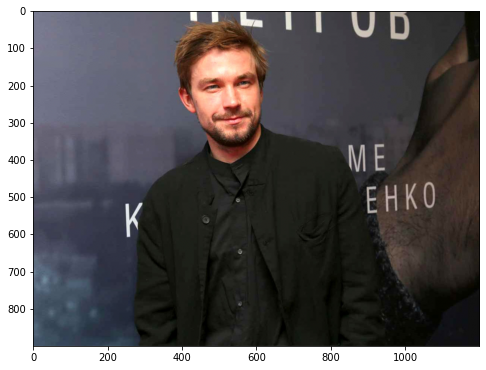

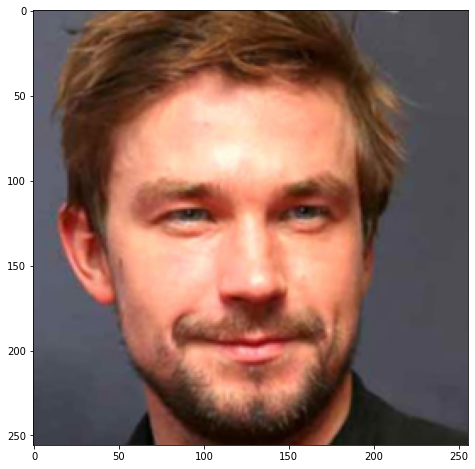

In [5]:
Xs_raw = cv2.imread(source_image_path)

plt.figure(figsize=(8,8))
plt.imshow(Xs_raw[:,:,::-1]/255)

# Получаем 5 лэндмарок лица
ldmk = get_ldmrks(Xs_raw)
# Получаем повернутый bbox такой, что лицо в нем выровнено
bb, _, _ = get_bb(Xs_raw, ldmk)
# Вырезаем лицо по bbox и получаем выровненное лицо
Xs, _ = get_align_face(Xs_raw, bb)
Xs = cv2.resize(Xs, (256, 256))

plt.figure(figsize=(8,8))
plt.imshow(Xs[:,:,::-1]/255)  

Xs_raw = np.array(Xs)[:, :, ::-1]
Xs = test_transform(Xs)
Xs = Xs.unsqueeze(0).cuda()

# Рассчитываем эмбеддинг лица
with torch.no_grad():
    embeds = arcface(F.interpolate(Xs[:, :, 19:237, 19:237], (112, 112), mode='bilinear', align_corners=True))

### Обрабатываем target лица

In [6]:
files = glob.glob(os.path.join(target_frames_path,'*.*g'))
files.sort()

# создаем маску, по которой будем накладывать сгенерированное лицо
mask = np.zeros([256, 256], dtype=np.float)
for i in range(256):
    for j in range(256):
        dist = np.sqrt((i-128)**2 + (j-128)**2)/128
        dist = np.minimum(dist, 1)
        mask[i, j] = 1-dist
mask = cv2.dilate(mask, None, iterations=20)
        
size = () 
# создаем список для индексов кадров без лиц и список лэндмарок
no_faces = []
ldmrks = []
for i, file in enumerate(files):
    Xt_raw = cv2.imread(file)
    result = get_ldmrks(Xt_raw)
    if result is not None:
        ldmrks.append(result)
    else:
        no_faces.append(i)
ldmrks = np.array(ldmrks)
print("Кадры без лиц: ", no_faces)

Кадры без лиц:  []


### Сглаживание лэндмарок

In [7]:
# раздлеляем кадры на группы при условие, если между соседними кадрами резкий скачок лэндмарок
ldmrks_arrays = split_frames_on_parts(ldmrks)
# сглаживание лэндмарок
ldmrks_arrays_smooth = smooth_landmarks(ldmrks_arrays)
# объединяем все обратно
ldmrks_arrays_smooth = get_all_frames(ldmrks_arrays_smooth, no_faces)

Разделение видео по следующим кадрам:  [185, 186, 194]


/home/snapper/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


### Получение сглаженных боксов и генерация лиц 

0th frame has been processed


/home/snapper/anaconda3/envs/pytorch-env/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


50th frame has been processed
100th frame has been processed
150th frame has been processed
200th frame has been processed
250th frame has been processed


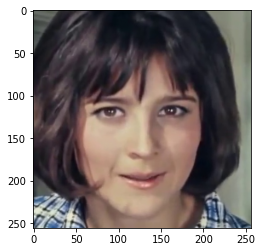

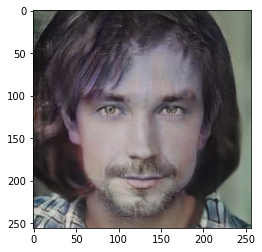

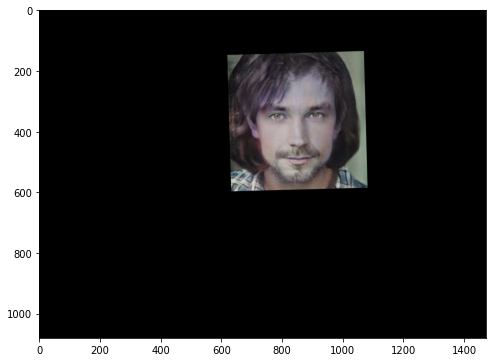

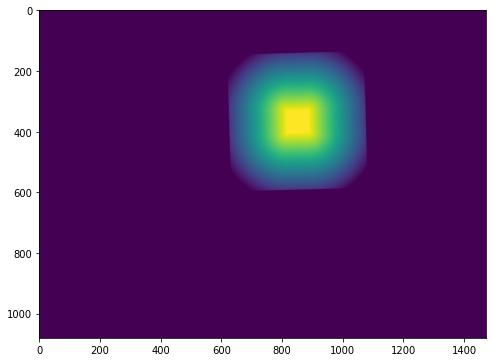

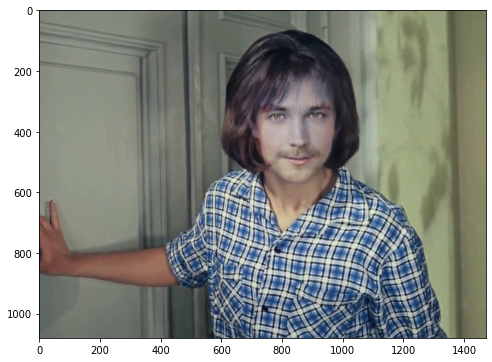

In [8]:
for ind, (file, ldmrk) in enumerate(zip(files, ldmrks_arrays_smooth)):
    Xt_raw = cv2.imread(file)
    
    if ldmrk is None:
        cv2.imwrite(os.path.join(target_frames_bb_path,'%08d.jpg'%ind), Xt_raw)
        cv2.imwrite(os.path.join(result_frames_path,'%08d.jpg'%ind), Xt_raw)
        continue
    
    # Получаем повернутый bbox такой, что лицо в нем выровнено
    bb, center_bb, Xt_raw_bb = get_bb(Xt_raw, ldmrk)
    cv2.imwrite(os.path.join(target_frames_bb_path,'%08d.jpg'%ind), Xt_raw_bb[:,:,::-1])
    # Вырезаем лицо по bbox и получаем выровненное лицо
    Xt, M_inverse = get_align_face(Xt_raw, bb) 
        
    if Xt is None:
        continue
        
    Xt_initial_shape = (Xt.shape[0], Xt.shape[1])
    Xt = cv2.resize(Xt, (256, 256))     
    cv2.imwrite(os.path.join(target_frames_crop_path,'%08d.jpg'%ind), Xt)
    
    # отображаем 50 кадр для налядности
    if ind == 50:
        plt.figure(figsize=(4,4))
        plt.imshow(Xt[:,:,::-1]/255)
        
    Xt_raw = Xt_raw.astype(np.float)/255.0
    size = (Xt_raw.shape[1],Xt_raw.shape[0])
    Xt = test_transform(Xt)
    Xt = Xt.unsqueeze(0).cuda()
    
    # замена лица
    with torch.no_grad():
        Yt, _ = G(Xt, embeds)
        Yt = Yt.squeeze().detach().cpu().numpy().transpose([1, 2, 0])*0.5 + 0.5 
        
    cv2.imwrite(os.path.join(result_frames_crop_path,'%08d.jpg'%ind), Yt*255)
    # отображаем face swap
    if ind == 50:
        plt.figure(figsize=(4,4))
        plt.imshow(Yt[:, :, ::-1])
    
    # поворачиваем сгенерированное лицо так, чтобы оно правильно встало в кадр
    Yt = cv2.resize(Yt, Xt_initial_shape)
    Yt_trans_inv = cv2.warpPerspective(Yt, M_inverse, size)
    # отображаем этот результат
    if ind == 50:
        plt.figure(figsize=(8,8))
        plt.imshow(Yt_trans_inv[:,:,::-1])
    
    # поворачиваем маску
    mask_resize = cv2.resize(mask.copy(), Xt_initial_shape)
    warped_mask = cv2.warpPerspective(mask_resize, M_inverse, size)
    warped_mask = np.expand_dims(warped_mask, 2)
    if ind == 50:
        plt.figure(figsize=(8,8))
        plt.imshow(warped_mask)
    
    # объединяем исходный кадр и результат генерации по маске
    Yt_trans_inv = warped_mask*Yt_trans_inv + (1-warped_mask)*Xt_raw
    # отображаем итоговый результат
    if ind == 50:
        plt.figure(figsize=(8,8))
        plt.imshow(Yt_trans_inv[:,:,::-1])

    cv2.imwrite(os.path.join(result_frames_path,'%08d.jpg'%ind), Yt_trans_inv*255)
    if(ind % 50 == 0):
        print("%dth frame has been processed"%ind)
#     ind += 1

### Создаем 4 видео

1 видео - итоговый результат переноса лица

2 видео - видео из target кадров с выделенным bbox и лэндмарками

3 видео - видео, собранное из сгенерированных кропов

4 видео - видео, собранное из target кропов

In [9]:
videos_save_path = [result_video_save_path, result_video_save_bb_path, result_video_save_crop_path, target_video_save_crop_path]
frames_path = [result_frames_path, target_frames_bb_path, result_frames_crop_path, target_frames_crop_path]

for i, (video_save_path, frame_path) in enumerate(zip(videos_save_path, frames_path)):
    print("start generate video")
    if i > 1:
        size=(256,256)
    videowriter = cv2.VideoWriter(video_save_path,cv2.VideoWriter_fourcc('M','J','P','G'),fps,size)
    files = glob.glob(os.path.join(frame_path,'*.*g'))
    files.sort()
    count = 0
    for file in files:
        img = cv2.imread(file)
        videowriter.write(img)
        if(count % 50 == 0):
            print("%dth frames has been convert to video" %count)
        count +=1
    videowriter.release()

start generate video
0th frames has been convert to video
50th frames has been convert to video
100th frames has been convert to video
150th frames has been convert to video
200th frames has been convert to video
250th frames has been convert to video
start generate video
0th frames has been convert to video
50th frames has been convert to video
100th frames has been convert to video
150th frames has been convert to video
200th frames has been convert to video
250th frames has been convert to video
start generate video
0th frames has been convert to video
50th frames has been convert to video
100th frames has been convert to video
150th frames has been convert to video
200th frames has been convert to video
250th frames has been convert to video
start generate video
0th frames has been convert to video
50th frames has been convert to video
100th frames has been convert to video
150th frames has been convert to video
200th frames has been convert to video
250th frames has been convert t